In [19]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymysql
import pymysql.cursors
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [20]:
%matplotlib inline
#为了使画出来的图支持 retina格式
%config InlineBackend.figure_format = 'retina'

In [3]:
def connectToDB():
    return pymysql.connect(
        host='rtm-db.cmguqnu4wehw.us-west-2.rds.amazonaws.com', 
        port=3306, user='rtmtest', 
        passwd='rtmtest123', 
        db='hotel_price_db', 
        charset="utf8", 
        use_unicode=True
    )

In [4]:
def getHotelPricesInDB(cnx):
    cursor = cnx.cursor()
    cursor.execute("SELECT le_hotel_price FROM lesaintsul_info")
    results = cursor.fetchall()
    # Here we de-tuple the results into a list
    list_result = []
    for i in range(0, len(results)):
        temp = results[i][0].replace(',','')
        list_result.append(int(temp))
#         results[i] = results[i][0]
    return list_result

In [5]:
def save_to_csv(content: list):
    #字典中的key值即为csv中列名
    dataframe = pd.DataFrame({'price':content})

    #将DataFrame存储为csv,index表示是否显示行名，default=True
    dataframe.to_csv("price.csv",index=False,sep=',')

In [6]:
def readDB_and_save_to_csv():
    cnx = connectToDB()
    hotelPrices = getHotelPricesInDB(cnx)
    # print(hotelPrices)
    save_to_csv(hotelPrices)

In [3]:
# normfun正态分布函数，mu: 均值，sigma:标准差，pdf:概率密度函数，np.exp():概率密度函数公式
# https://zh.wikipedia.org/wiki/%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83
def normfun(x, mu, sigma):
#     pdf = np.random.normal(loc=mu, scale=sigma, size=None)
    pdf = np.exp(-((x - mu)**2) / (2* sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf

In [16]:
def draw_normal_distribution_read_test():
    price_data = pd.read_csv('price.csv')
    print(len(price_data))
    price_data.head(10)
    price = price_data['price']
    mean = price.mean()
    print("均值mean="+str(mean))
    # 标准差
    std = price.std()
    print("标准差std="+str(std))
    # x的范围为-100, 1400，以1为单位,需x根据范围调试
    x = np.arange(price.min(), price.max(),1)

    # x数对应的概率密度
#     y = normfun(x, mean, std)
    y = stats.norm.pdf(x, mean, std)

    # 参数,颜色，线宽
    plt.plot(x,y, color='g',linewidth = 3)

    #数据，数组，颜色，颜色深浅，组宽，显示频率
    plt.hist(price, bins='auto', color = 'r',alpha=0.5,rwidth= 0.9, normed=True)

    plt.title('Price distribution')
    plt.xlabel('Price score')
    plt.ylabel('Probability')
    plt.show()

In [21]:
def read_from_csv(filename : str):
    meta_price_data = pd.read_csv(filename)
    return meta_price_data

In [22]:
# 去除退款、房间大于1000美元的房价
def data_preprocess(price_data, minnum: int, maxnum: int):
    price_data = price_data[(minnum<price_data['BASE_PRICE_AMT_USD']) & (price_data['BASE_PRICE_AMT_USD']<=maxnum)]
    return price_data

In [23]:
def draw_normal_distribution_read_prod(price_data, minnum: int, maxnum: int):
    price = price_data['BASE_PRICE_AMT_USD']
    mean = price.mean()
    # 标准差
    std = price.std()
    
    # x的范围为 (0-3000，以1为单位,需x根据范围调试
    x = np.arange(minnum, maxnum, 1)

    # x数对应的概率密度
    # y = normfun(x, mean, std)
    y = stats.norm.pdf(x, mean, std)

    # 参数, 颜色，线宽
    l1, = plt.plot(x, y, 'g--', linewidth = 3)

    sns.set_palette("hls") 
    mpl.rc("figure", figsize=(6,4)) 
    sns.distplot(price, bins=20, kde_kws={"color":"red", "lw":3 }, hist_kws={ "color": "b" }) 
    
    #数据，数组，颜色，颜色深浅，组宽，显示频率
    (counts, bins, patch) = plt.hist(price, bins=20, color = 'blue',alpha=0.5,rwidth= 0.8, normed=True)
#     print(counts)
#     print(bins)
#     print(patch)
    plt.title(r'Price Histogram : $\mu={0}$,$\sigma={1}$'.format(mean, std))
    plt.xlabel('Price score')
    plt.ylabel('Probability')
    
    # 设置legend
    # 在绘制时设置lable, 逗号是必须的
    
    plt.legend(handles = [l1], labels = ['Normal Distribution'], loc = 'best')
    plt.show()

In [17]:
def draw_normal_distribution_read():
    price_data = pd.read_csv('trans_fact_201901.csv')
#     print(len(price_data))
#     print(price_data.head(10))
#     price = price_data['BASE_PRICE_AMT_USD']
#     print(temp.head(10))
#     price = price_data['BASE_PRICE_AMT_USD']
#     print(price.head(10))
#     print(price.max())
#     print(price.min())
    
    price_data = data_preprocess(meta_price_data, 4000, 4000000) # 1.857144 - 2.190203 3.63078 4.26449
    print(len(price_data))
    

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


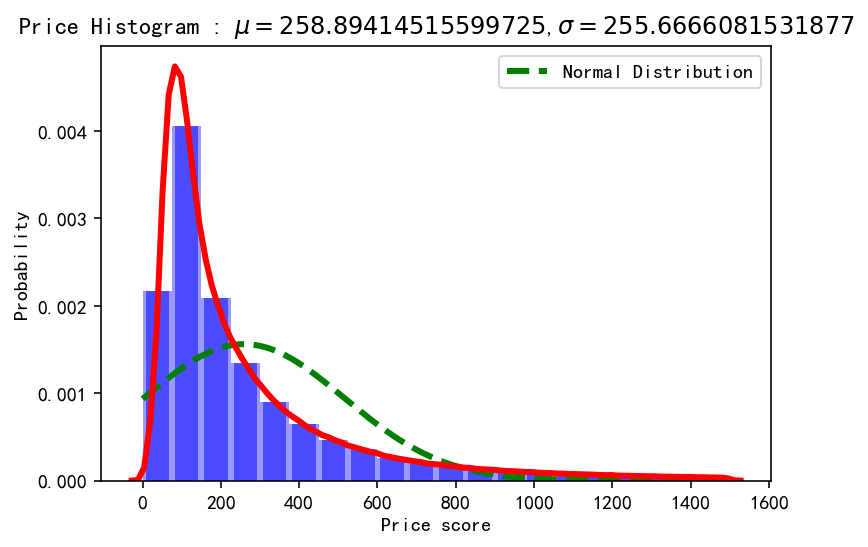

In [25]:
if __name__ == '__main__':
    minnum, maxnum = 0, 1200
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess(meta_price_data, minnum, maxnum)
    draw_normal_distribution_read_prod(price_data, minnum, maxnum)
    
    # draw_normal_distribution_read()
    # draw_normal_distribution_read_test()